# Importing Necessary Modules

In [166]:
import pandas as pd
import numpy as np

#word stemming
import nltk
nltk.download('punkt')
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize

#data processing
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.models import Sequential 
from keras.layers import Dense, Embedding, Flatten 
from keras.datasets import imdb 
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from keras.utils.vis_utils import plot_model
from sklearn.feature_extraction.text import TfidfVectorizer

#Visualization 
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

#Under and Oversampling
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

#Evaluation
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import recall_score
import matplotlib.pyplot as plt
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score


#models
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC 
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier


[nltk_data] Downloading package punkt to /Users/glendawee/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Preliminary TFIDF Model 
Importing the data 

In [167]:
transcript_filepath = "compiled_transcripts/clean_compiled_transcripts.csv"
# df_transcript = pd.read_csv(transcript_filepath, index_col = "Participant_ID")
df_transcript = pd.read_csv(transcript_filepath)

column_list = df_transcript.columns.tolist()
print(column_list)

df_transcript.head(10)

['Participant_ID', 'Transcript', 'PHQ_Score', 'PHQ_Binary']


,Participant_ID,Transcript,PHQ_Score,PHQ_Binary
0,300,good atlanta um my parents um i love it i like...,2,0
1,301,thank you mmm k i good thank you i los angeles...,3,0
2,302,i fine yourself i los angeles part okay um my ...,4,0
3,303,okay bout yourself yeah oh well it big broad l...,0,0
4,304,i good um los angeles um cool weather beaches ...,6,0
5,305,i alright uh originally i uh born glendale i h...,7,0
6,306,fine uh mhm uh career career possibilities uh ...,0,0
7,307,um moscow um my family moved us i moved eventu...,4,0
8,308,los angeles yes um southern lifestyle beaches ...,22,1
9,309,yeah i good uh uh acting stuff like entertain ...,15,1


## Processing Data 
We have these different functions to help us calculate the tfidf.

In [168]:
# # choose some words to be stemmed 
# words_program = ["program", "programs", "programer", "programing", "programers"] 
# words_complete = ["complete", "completely", "completing", "completion", "completes"] 
# words_absolute = ["absolute", "absolutely"]
  
# for w in words_absolute: 
#     print(w, " : ", ps.stem(w)) 

In [169]:
def stem_text(text):
    ps = PorterStemmer()
    text = text.split()
    stemmed_text = []
    for w in text: 
        stemmed = ps.stem(w)
        stemmed_text.append(stemmed)
    return stemmed_text

stem_text("i my you me they we she he myself her shes")

['i', 'my', 'you', 'me', 'they', 'we', 'she', 'he', 'myself', 'her', 'she']

In [170]:
original_text = df_transcript.Transcript[0]
# df_transcript.Transcript = df_transcript.Transcript.apply(stem_text)
# filtered_text = df_transcript.Transcript[300]

print(f"The original text is:\n{original_text}")
# print("-------------------------------------------")
# print(f"The filtered text is:\n{filtered_text}")

The original text is:
good atlanta um my parents um i love it i like weather i like opportunities um yes um it took minute somewhat easy congestion it um i took business administration uh yeah i i break right i plan going back uh next semester uh probably open my business um specific reason i travel lot i pretty local year you little bit specific answer i like reading books i enjoy i enjoy cooking um exercising great i i i pretty good it um yeah um probably two weeks ago uh frustrated um i like bias um i like um someone says they going something they uh somewhat friendship i like play sports i enjoy uh going friends family playing games grandparents parents um yeah i mean they always given me great advice they always kept it real real close i would say going college right high school well i would done you know i would probably field career field uh taking job street i sure i could yes i sure maybe i graduated high school well uh i um i got my diploma my my diploma i finished school i m

# Visualizing the data 

In [171]:
vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1,2))
corpus = df_transcript["Transcript"]
x = vectorizer.fit(corpus)
x = vectorizer.transform(corpus)
dic_vocabulary = vectorizer.vocabulary_
phq_Score = df_transcript["PHQ_Score"]
phq_Binary = df_transcript.PHQ_Binary.to_numpy()

x_train, x_test, y_train, y_test = train_test_split(x, phq_Binary, test_size=0.2) 

x_train_dense = x_train.todense()
x_test_dense = x_test.todense()

x.toarray()
print(x.shape)
print(x.shape[0])

(181, 10000)
181


# Visualization of TFIDF 
There are no obvious clusters from the visualisations of these vectors. 

Green and not depressed:  126
Red and not depressed:  0
Green and depressed:  0
Red and depressed:  55


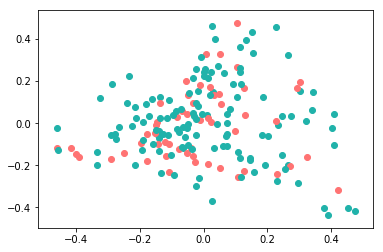

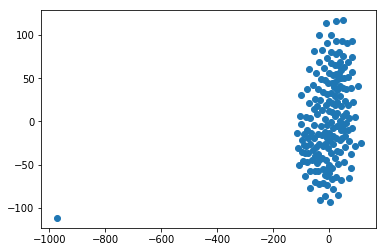

In [172]:
num_clusters = 2
num_seeds = 10
max_iterations = 300

labels_color_map = {
    0: '#20b2aa', 1: '#ff7373'
}

pca_num_components = 2
tsne_num_components = 2

# create k-means model with custom config
clustering_model = KMeans(
    n_clusters=num_clusters,
    max_iter=max_iterations,
    precompute_distances="auto",
    n_jobs=-1
)

# labels = clustering_model.fit_predict(x)

labels = phq_Binary
# print labels

x_dense = x.todense()

# ----------------------------------------------------------------------------------------------------------------------

reduced_data = PCA(n_components=pca_num_components).fit_transform(x_dense)
# print reduced_data

fig, ax = plt.subplots()

A = 0 #counter for green and y = 0 
B = 0 #counter for red and y = 0
C = 0 #counter for green and y = 1
D = 0 #counter for red & y = 1
    
for index, instance in enumerate(reduced_data):
#     print(instance)
#     print(index)
#     print(labels[index])
    # print instance, index, labels[index]
    pca_comp_1, pca_comp_2 = reduced_data[index]
    color = labels_color_map[labels[index]]
    ax.scatter(pca_comp_1, pca_comp_2, c=color)
    
    #to compare accuracy 
    y = phq_Binary[index] 
#     print("y = ", y)
#     print("color: ", color)
    
    if y == 0 and color == '#20b2aa':
        A += 1
    elif (y == 0 and color == '#ff7373'):
        B += 1
    elif (y == 1 and color == '#20b2aa'): 
        C += 1
    elif (y == 1 and color == '#ff7373'):
        D += 1
          
    
print("Green and not depressed: ", A)
print("Red and not depressed: ", B)
print("Green and depressed: ", C)
print("Red and depressed: ", D)


        
    
plt.show()



# t-SNE plot
embeddings = TSNE(n_components=tsne_num_components)
Y = embeddings.fit_transform(x_dense)
plt.scatter(Y[:, 0], Y[:, 1], cmap=plt.cm.Spectral)
plt.show()

## Undersampling
Undersampling 

In [173]:
!pip3 install imblearn
!pip3 install jupyter


In [174]:
# the ratio of minority class to majority class will be 1 after resampling
us = RandomUnderSampler(random_state=42)

xu_train, yu_train = us.fit_sample(x_train, y_train) 
xu_train_dense, yu_train_dense = us.fit_sample(x_train_dense, y_train) 


## Oversampling

In [175]:
os = SMOTE() 
xo_train, yo_train = os.fit_sample(x_train, y_train)
xo_train_dense, yo_train_dense = us.fit_sample(x_train_dense, y_train) 


# Evaluation Metrics
For depression, anything that doesn't account for false negatives could be harmful. Therefore, we take recall as a better measure than precision. 

In [176]:
def evaluate_on_training_set(y_test, y_pred):
  # Calculate AUC
  print("AUC is: ", roc_auc_score(y_test, y_pred))
  
  # print out recall and precision
  print(classification_report(y_test, y_pred, labels=np.unique(y_pred)))
  
  # print out confusion matrix
  print("Confusion Matrix: \n", confusion_matrix(y_test, y_pred))

  # # calculate points for ROC curve
  fpr, tpr, thresholds = roc_curve(y_test, y_pred)
  
  # Plot ROC curve
  plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc_score(y_test, y_pred))
  plt.plot([0, 1], [0, 1], 'k--')
  plt.ylim([0.0, 1.0])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver Operating Characteristic')

## k-cross

In [177]:
def k_cross(model, X, y, k=10, n=1, random_state=42):
    f1_scores = []
    recall_scores = []
    rkf = RepeatedKFold(n_splits=k, n_repeats=n, random_state=random_state)
    for train_index, val_index in rkf.split(X):
        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]
        
        model.fit(X_train, y_train) 
        
        y_pred = model.predict(X_val)
        f1 = f1_score(y_val, y_pred, labels=np.unique(y_pred))
        f1_scores.append(f1)
        recall = recall_score(y_val, y_pred, labels=np.unique(y_pred))
        recall_scores.append(recall)
        
    return f1_scores, recall_scores

In [178]:
def evaluate_model(model):
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    evaluate_on_training_set(y_test, y_pred)
    
    return model

# Run Model 

In [179]:
def run_model(input_model, X_train, X_test, y_train, y_test):
    model = input_model
    model.fit(X_train, y_train)
    y_pred = model.predict(x_test)
    evaluate_on_training_set(y_test, y_pred)
    
    return model

# Training Models
normal, under and oversampling methods were used for all 

### Naive Bayes Model
We try multinomial NB because it's better suited to vectorized text.  

NORMAL SAMPLE
AUC is:  0.5
             precision    recall  f1-score   support

          0       0.70      1.00      0.83        26

avg / total       0.70      1.00      0.83        26

Confusion Matrix: 
 [[26  0]
 [11  0]]
F1:  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Recall:  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


/Users/glendawee/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


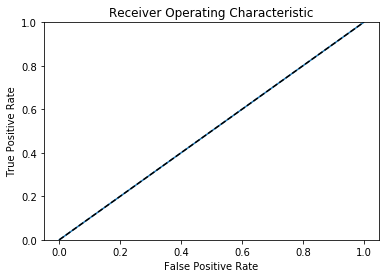

In [180]:
clf = MultinomialNB()

print("NORMAL SAMPLE")
run_model(clf, x_train, x_test, y_train, y_test)

# run_model(clf, x_train, x_test, y_train, y_test)
f1_scores, recall_scores = k_cross(clf, x_train, y_train)

print("F1: ", f1_scores)
print("Recall: ", recall_scores)


UNDERSAMPLE
AUC is:  0.6398601398601399
             precision    recall  f1-score   support

          0       0.86      0.46      0.60        26
          1       0.39      0.82      0.53        11

avg / total       0.72      0.57      0.58        37

Confusion Matrix: 
 [[12 14]
 [ 2  9]]
F1:  [0.2857142857142857, 0.5454545454545454, 0.5, 0.5454545454545454, 0.8000000000000002, 0.6666666666666666, 0.7272727272727272, 0.6153846153846153, 0.0, 0.5]
Recall:  [0.16666666666666666, 1.0, 1.0, 1.0, 0.8, 1.0, 0.8, 1.0, 0.0, 0.4]
F1 mean:  0.5185947385947386
Recall mean:  0.7166666666666668


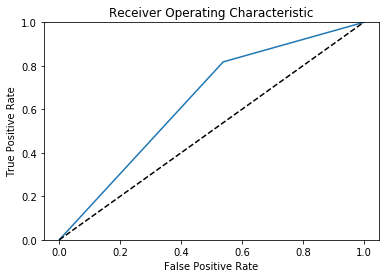

In [181]:
print("UNDERSAMPLE")
run_model(clf, xu_train, x_test, yu_train, y_test)

# run_model(clf, x_train, x_test, y_train, y_test)
f1_scores, recall_scores = k_cross(clf, xu_train, yu_train)

print("F1: ", f1_scores)
print("Recall: ", recall_scores)

print("F1 mean: ", np.mean(f1_scores))
print("Recall mean: ", np.mean(recall_scores))

OVERSAMPLING
AUC is:  0.6206293706293707
             precision    recall  f1-score   support

          0       0.85      0.42      0.56        26
          1       0.38      0.82      0.51        11

avg / total       0.71      0.54      0.55        37

Confusion Matrix: 
 [[11 15]
 [ 2  9]]
F1:  [0.6923076923076924, 0.7407407407407407, 0.8148148148148148, 0.5833333333333334, 0.6153846153846153, 0.846153846153846, 0.8571428571428571, 0.6666666666666666, 0.8148148148148148, 0.8333333333333333]
Recall:  [1.0, 1.0, 1.0, 0.875, 0.8888888888888888, 1.0, 1.0, 1.0, 1.0, 1.0]
F1 mean:  0.7464692714692714
Recall mean:  0.976388888888889


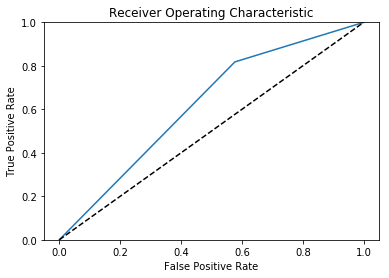

In [182]:
print("OVERSAMPLING")
run_model(clf, xo_train, x_test, yo_train, y_test)

# run_model(clf, x_train, x_test, y_train, y_test)
f1_scores, recall_scores = k_cross(clf, xo_train, yo_train)

print("F1: ", f1_scores)
print("Recall: ", recall_scores)

print("F1 mean: ", np.mean(f1_scores))
print("Recall mean: ", np.mean(recall_scores))

### Gaussian Naive Bayes
we aren't trying this because sparse data almost certainly does not meet the assumptions of the algorithm – when the bulk of the values are zero, a simple Gaussian is not a good fit to the data, and will almost never lead to a useful classification.

### SVM Model

NORMAL
AUC is:  0.5
             precision    recall  f1-score   support

          0       0.70      1.00      0.83        26

avg / total       0.70      1.00      0.83        26

Confusion Matrix: 
 [[26  0]
 [11  0]]
F1:  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Recall:  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
F1 mean:  0.0
Recall mean:  0.0


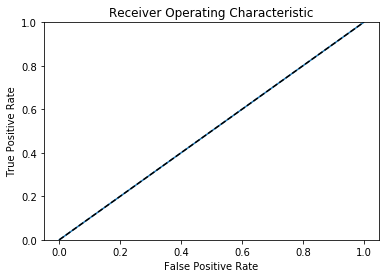

In [183]:
svc = SVC(C = 10, gamma= "auto", kernel = "rbf")

print("NORMAL")
run_model(svc, x_train, x_test, y_train, y_test)
f1_scores, recall_scores = k_cross(svc, x_train, y_train)

print("F1: ", f1_scores)
print("Recall: ", recall_scores)

print("F1 mean: ", np.mean(f1_scores))
print("Recall mean: ", np.mean(recall_scores))

UNDERSAMPLING
AUC is:  0.5751748251748252
             precision    recall  f1-score   support

          0       0.79      0.42      0.55        26
          1       0.35      0.73      0.47        11

avg / total       0.66      0.51      0.53        37

Confusion Matrix: 
 [[11 15]
 [ 3  8]]
F1:  [0.0, 0.5, 0.5, 0.5, 0.0, 0.6153846153846153, 0.0, 0.6153846153846153, 0.0, 0.0]
Recall:  [0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0]
F1 mean:  0.2730769230769231
Recall mean:  0.5


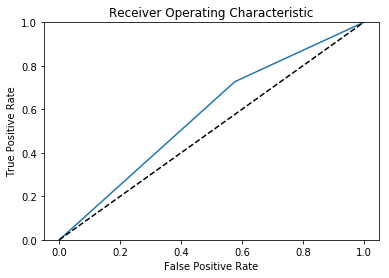

In [184]:
print("UNDERSAMPLING")
run_model(svc, xu_train, x_test, yu_train, y_test)
f1_scores, recall_scores = k_cross(svc, xu_train, yu_train)

print("F1: ", f1_scores)
print("Recall: ", recall_scores)

print("F1 mean: ", np.mean(f1_scores))
print("Recall mean: ", np.mean(recall_scores))

OVERSAMPLING
AUC is:  0.5611888111888111
             precision    recall  f1-score   support

          0       0.75      0.58      0.65        26
          1       0.35      0.55      0.43        11

avg / total       0.63      0.57      0.59        37

Confusion Matrix: 
 [[15 11]
 [ 5  6]]
F1:  [0.6206896551724138, 0.7272727272727272, 0.0, 0.5714285714285715, 0.6206896551724138, 0.0, 0.0, 0.6206896551724138, 0.0, 0.8695652173913044]
Recall:  [1.0, 0.8, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0]
F1 mean:  0.40303354816098447
Recall mean:  0.58


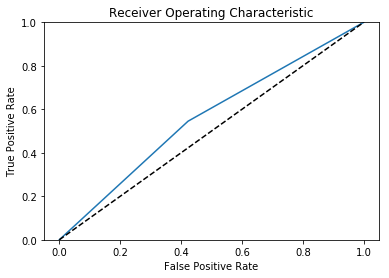

In [185]:
print("OVERSAMPLING")
run_model(svc, xo_train, x_test, yo_train, y_test)
f1_scores, recall_scores = k_cross(svc, xo_train, yo_train)

print("F1: ", f1_scores)
print("Recall: ", recall_scores)

print("F1 mean: ", np.mean(f1_scores))
print("Recall mean: ", np.mean(recall_scores))

## AdaboostClassifier

NORMAL
AUC is:  0.5979020979020979
             precision    recall  f1-score   support

          0       0.75      0.92      0.83        26
          1       0.60      0.27      0.37        11

avg / total       0.71      0.73      0.69        37

Confusion Matrix: 
 [[24  2]
 [ 8  3]]
F1:  0.25472527472527473
Recall:  0.20952380952380953


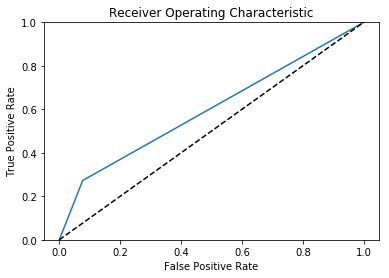

In [186]:
abc = AdaBoostClassifier(n_estimators=1000, learning_rate=0.1)

print("NORMAL")
run_model(abc, x_train, x_test, y_train, y_test)
f1_scores, recall_scores = k_cross(abc, x_train, y_train)

print("F1: ", np.mean(f1_scores))
print("Recall: ", np.mean(recall_scores))

UNDERSAMPLING
AUC is:  0.6905594405594406
             precision    recall  f1-score   support

          0       0.85      0.65      0.74        26
          1       0.47      0.73      0.57        11

avg / total       0.74      0.68      0.69        37

Confusion Matrix: 
 [[17  9]
 [ 3  8]]
F1:  [0.7692307692307692, 0.28571428571428575, 0.3333333333333333, 0.5, 0.0, 0.6666666666666665, 0.8333333333333333, 0.75, 0.6666666666666666, 0.6666666666666665]
Recall:  [0.8333333333333334, 0.3333333333333333, 0.3333333333333333, 0.6666666666666666, 0.0, 0.75, 1.0, 0.75, 0.5, 0.6]
F1 mean:  0.5471611721611722
Recall mean:  0.5766666666666667


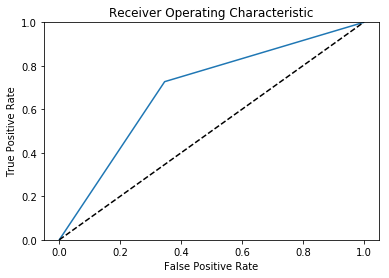

In [187]:
print("UNDERSAMPLING")
run_model(abc, xu_train, x_test, yu_train, y_test)
f1_scores, recall_scores = k_cross(abc, xu_train, yu_train)

print("F1: ", f1_scores)
print("Recall: ", recall_scores)

print("F1 mean: ", np.mean(f1_scores))
print("Recall mean: ", np.mean(recall_scores))

OVERSAMPLING
AUC is:  0.6433566433566434
             precision    recall  f1-score   support

          0       0.77      0.92      0.84        26
          1       0.67      0.36      0.47        11

avg / total       0.74      0.76      0.73        37

Confusion Matrix: 
 [[24  2]
 [ 7  4]]
F1:  [0.7058823529411765, 0.888888888888889, 0.9565217391304348, 0.823529411764706, 0.5333333333333333, 0.8421052631578948, 0.9166666666666666, 0.8888888888888888, 0.8421052631578948, 0.8000000000000002]
Recall:  [0.6666666666666666, 0.8, 1.0, 0.875, 0.4444444444444444, 0.7272727272727273, 0.9166666666666666, 0.8888888888888888, 0.7272727272727273, 0.8]
F1 mean:  0.8197921807929884
Recall mean:  0.784621212121212


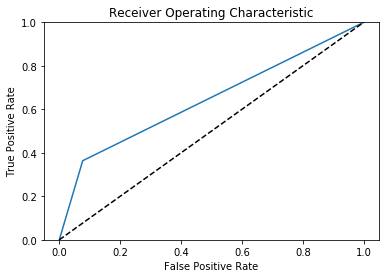

In [188]:
print("OVERSAMPLING")
run_model(abc, xo_train, x_test, yo_train, y_test)
f1_scores, recall_scores = k_cross(abc, xo_train, yo_train)

print("F1: ", f1_scores)
print("Recall: ", recall_scores)

print("F1 mean: ", np.mean(f1_scores))
print("Recall mean: ", np.mean(recall_scores))

# Decision Tree

In [189]:
def find_best_tree_model(upper_depth, upper_leaf):
    best_f1_model = None
    best_recall_model = None
    best_f1 = -1
    best_recall = -1
    
    for depth in range(1, upper_depth + 1):
        for leaf in range(1, upper_leaf + 1):
            model = DecisionTreeClassifier(random_state=42, max_depth=depth, min_samples_leaf=leaf) 
            
            f1_scores, recall_scores = k_cross(model, x_train, y_train)
            f1 = np.mean(f1_scores)
            recall = np.mean(recall_scores)
            
            if f1 > best_f1:
                print(f"depth: {depth}, leaf: {leaf}: f1 = {f1} > best f1 = {best_f1}")
                best_f1 = f1
                best_f1_model = model
                
            if recall > best_recall:
                print(f"depth: {depth}, leaf: {leaf}: recall = {recall} > best recall = {best_recall}")
                best_recall = recall
                best_recall_model = model
    
    return best_f1_model, best_recall_model

best_tree_f1_model, best_tree_recall_model = find_best_tree_model(20, 30)

/Users/glendawee/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


depth: 1, leaf: 1: f1 = 0.06000000000000001 > best f1 = -1
depth: 1, leaf: 1: recall = 0.039285714285714285 > best recall = -1
depth: 1, leaf: 9: f1 = 0.1069047619047619 > best f1 = 0.06000000000000001
depth: 1, leaf: 9: recall = 0.08095238095238096 > best recall = 0.039285714285714285
depth: 2, leaf: 9: f1 = 0.25682539682539685 > best f1 = 0.1069047619047619
depth: 2, leaf: 9: recall = 0.21428571428571427 > best recall = 0.08095238095238096
depth: 2, leaf: 24: recall = 0.24761904761904763 > best recall = 0.21428571428571427
depth: 2, leaf: 25: recall = 0.28095238095238095 > best recall = 0.24761904761904763
depth: 3, leaf: 9: f1 = 0.26519480519480515 > best f1 = 0.25682539682539685
depth: 4, leaf: 9: f1 = 0.311062271062271 > best f1 = 0.26519480519480515
depth: 4, leaf: 9: recall = 0.35 > best recall = 0.28095238095238095
depth: 5, leaf: 9: f1 = 0.33355311355311357 > best f1 = 0.311062271062271


AUC is:  0.4370629370629371
             precision    recall  f1-score   support

          0       0.67      0.69      0.68        26
          1       0.20      0.18      0.19        11

avg / total       0.53      0.54      0.53        37

Confusion Matrix: 
 [[18  8]
 [ 9  2]]


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=9, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best')

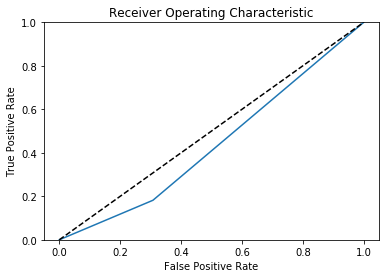

In [190]:
evaluate_model(best_tree_f1_model)

AUC is:  0.45629370629370636
             precision    recall  f1-score   support

          0       0.68      0.73      0.70        26
          1       0.22      0.18      0.20        11

avg / total       0.54      0.57      0.55        37

Confusion Matrix: 
 [[19  7]
 [ 9  2]]


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=4,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=9, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best')

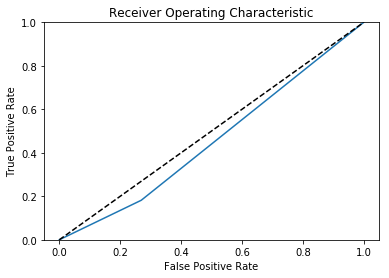

In [191]:
evaluate_model(best_tree_recall_model)

## Random Forest

this model appears to have some hope, not sure if im having false hope 
- possibly because no undersampling was used, so in the end the model just favours the majority class

In [192]:
def find_best_forest_model(n_estimators):
    best_f1_model = None
    best_recall_model = None
    best_f1 = -1
    best_recall = -1
    
    for estimator in range(1, n_estimators + 1):
        model = RandomForestClassifier(random_state=42, n_estimators=estimator) 
        
        f1_scores, recall_scores = k_cross(model, x_train, y_train)
        f1 = np.mean(f1_scores)
        recall = np.mean(recall_scores)

        if f1 > best_f1:
            print(f"estimator: {estimator}: f1 = {f1} > best f1 = {best_f1}")
            best_f1 = f1
            best_f1_model = model

        if recall > best_recall:
            print(f"estimator: {estimator}: recall = {recall} > best recall = {best_recall}")
            best_recall = recall
            best_recall_model = model
    
    return best_f1_model, best_recall_model

best_forest_f1_model, best_forest_recall_model = find_best_forest_model(20)

estimator: 1: f1 = 0.2932683982683983 > best f1 = -1
estimator: 1: recall = 0.28785714285714287 > best recall = -1


/Users/glendawee/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/glendawee/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/glendawee/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/glendawee/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/glendawee/anaconda3/lib/python3.7/sit

/Users/glendawee/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/glendawee/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/glendawee/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/glendawee/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/glendawee/anaconda3/lib/python3.7/sit

/Users/glendawee/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/glendawee/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/glendawee/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/glendawee/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/glendawee/anaconda3/lib/python3.7/sit

AUC is:  0.4248251748251748
             precision    recall  f1-score   support

          0       0.65      0.58      0.61        26
          1       0.21      0.27      0.24        11

avg / total       0.52      0.49      0.50        37

Confusion Matrix: 
 [[15 11]
 [ 8  3]]


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

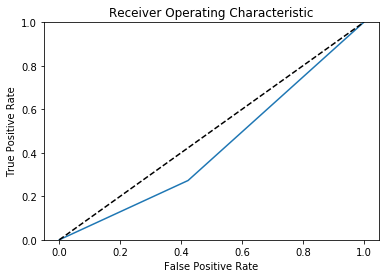

In [193]:
evaluate_model(best_forest_f1_model)